In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.0 MB/s eta 0:00:00


In [ ]:
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load DICOM image and preprocess it
def load_dicom_image(path):
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array.astype(np.float32)

    # Normalize image intensity to range [0, 255]
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Convert to uint8 (required for OpenCV)
    img = img.astype(np.uint8)

    return img

# Load fixed and moving images
fixed_img = load_dicom_image("/content/drive/MyDrive/CT/Train/IM000000_14.dcm")
moving_img = load_dicom_image("/content/drive/MyDrive/CT/Train/IM000000_12.dcm")

# Apply histogram equalization for better contrast
fixed_img = cv2.equalizeHist(fixed_img)
moving_img = cv2.equalizeHist(moving_img)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints_fixed, descriptors_fixed = sift.detectAndCompute(fixed_img, None)
keypoints_moving, descriptors_moving = sift.detectAndCompute(moving_img, None)

# Match keypoints using FLANN-based matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors_moving, descriptors_fixed, k=2)

# Apply Lowe's ratio test to filter matches
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

# If sufficient matches are found, estimate transformation
if len(good_matches) > 10:
    src_pts = np.float32([keypoints_moving[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints_fixed[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute affine transformation using RANSAC
    transformation_matrix, _ = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC)

    # Apply affine transformation to align images
    aligned_img = cv2.warpAffine(moving_img, transformation_matrix, (fixed_img.shape[1], fixed_img.shape[0]))

    # Display results
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1), plt.imshow(fixed_img, cmap='gray'), plt.title("Fixed Image")
    plt.subplot(1, 2, 2), plt.imshow(aligned_img, cmap='gray'), plt.title("Aligned Image")
    plt.show()
else:
    print("Not enough good matches for alignment.")


Not enough good matches for alignment.


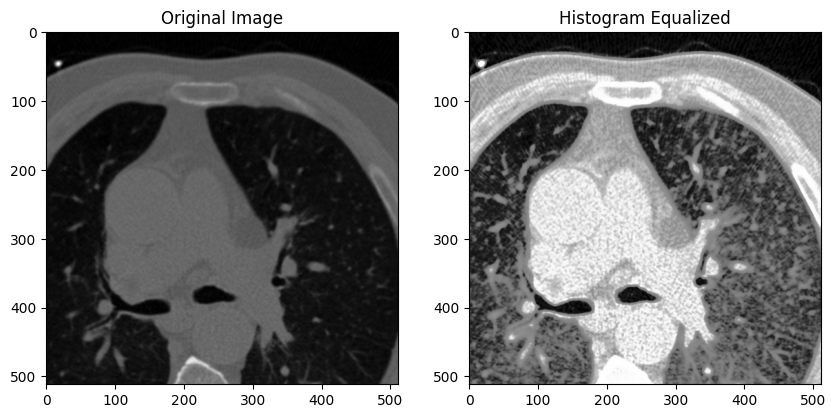

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image
img = load_dicom_image("/content/drive/MyDrive/CT/Train/IM000000_14.dcm")

# Apply histogram equalization
equalized_img = cv2.equalizeHist(img)

# Display original and equalized images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(img, cmap='gray'), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(equalized_img, cmap='gray'), plt.title("Histogram Equalized")
plt.show()


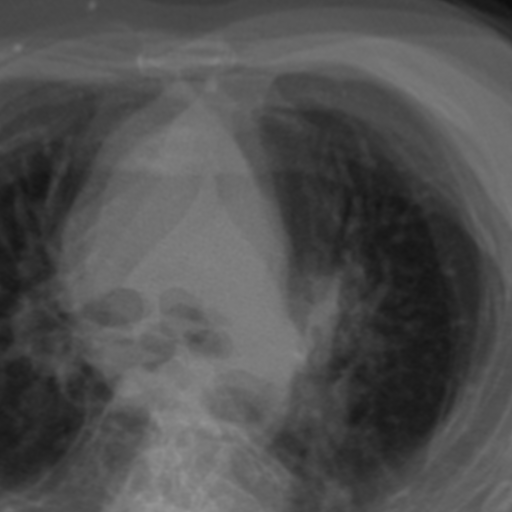

In [ ]:
import pydicom
import cv2
import numpy as np
import glob
from google.colab.patches import cv2_imshow
# Load all DICOM images from a folder
def load_dicom_images(folder_path):
    image_list = []
    for file in glob.glob(folder_path + "/*.dcm"):
        dicom = pydicom.dcmread(file)
        img = dicom.pixel_array.astype(np.float32)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  # Normalize intensity
        image_list.append(img)
    return np.array(image_list)

# Compute the average image (Atlas)
def create_atlas(image_stack):
    return np.mean(image_stack, axis=0)  # Mean intensity projection

# Load CT images
ct_images = load_dicom_images("/content/drive/MyDrive/CT/Train/")  # Folder containing DICOMs
atlas = create_atlas(ct_images)

# Save or display the atlas image
cv2.imwrite("atlas.png", atlas.astype(np.uint8))
cv2_imshow(atlas.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()


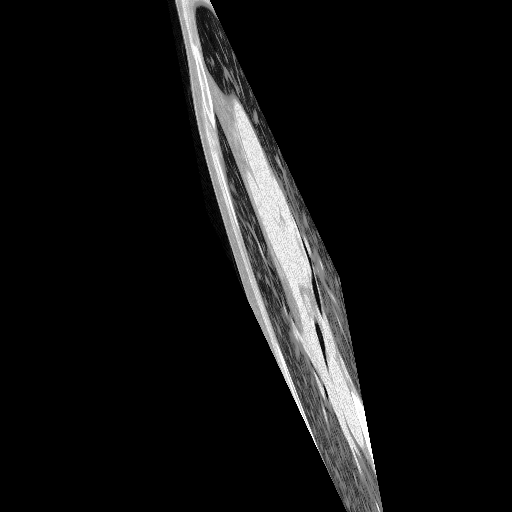

In [ ]:
# Load the new CT scan
new_ct = pydicom.dcmread("/content/drive/MyDrive/CT/Train/IM000000_14.dcm").pixel_array.astype(np.float32)
new_ct = cv2.normalize(new_ct, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Convert atlas to uint8 for OpenCV
atlas = atlas.astype(np.uint8)

# Apply histogram equalization for better contrast
new_ct = cv2.equalizeHist(new_ct)
atlas = cv2.equalizeHist(atlas)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints_atlas, descriptors_atlas = sift.detectAndCompute(atlas, None)
keypoints_new, descriptors_new = sift.detectAndCompute(new_ct, None)

# Match keypoints using FLANN-based matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors_new, descriptors_atlas, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

# If sufficient matches are found, estimate transformation
if len(good_matches) > 10:
    src_pts = np.float32([keypoints_new[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints_atlas[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute affine transformation using RANSAC
    transformation_matrix, _ = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC)

    # Apply affine transformation to align images
    aligned_ct = cv2.warpAffine(new_ct, transformation_matrix, (atlas.shape[1], atlas.shape[0]))

    # Display results
    cv2_imshow(aligned_ct)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Not enough good matches for alignment.")


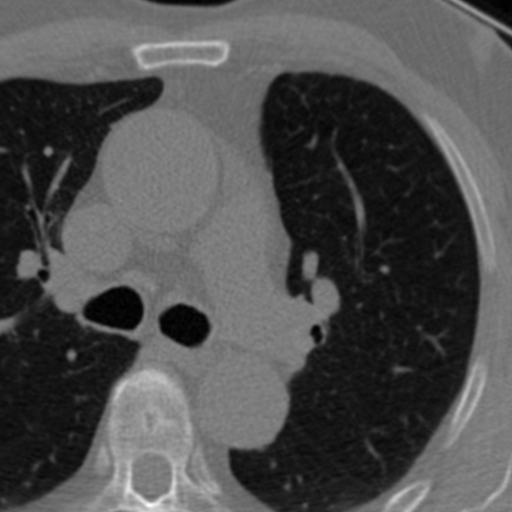

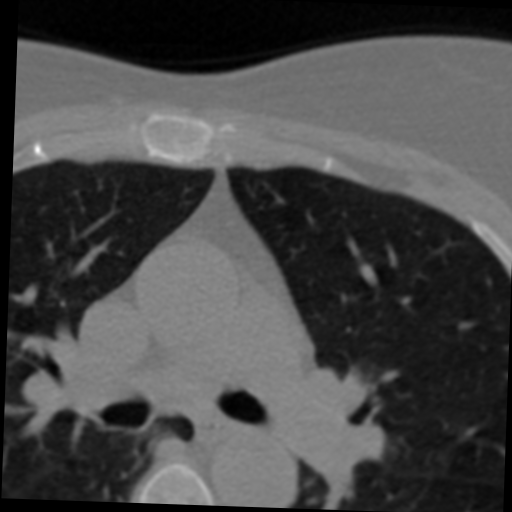

In [ ]:
import pydicom
import cv2
import numpy as np

# Load DICOM images
def load_dicom_image(path):
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array.astype(np.float32)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  # Normalize
    return img.astype(np.uint8)
def load_dicom_images(folder_path):
    image_list = []
    for file in glob.glob(folder_path + "/*.dcm"):
        dicom = pydicom.dcmread(file)
        img = dicom.pixel_array.astype(np.float32)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  # Normalize intensity
        image_list.append(img)
    return np.array(image_list)

# Load the Atlas and New CT Image
atlas = load_dicom_image("/content/drive/MyDrive/CT/Train/IM000000_11.dcm")

new_ct = load_dicom_image("/content/drive/MyDrive/CT/Train/IM000000_18.dcm")


# Step 1: Resize new CT to match the atlas size
new_ct_resized = cv2.resize(new_ct, (atlas.shape[1], atlas.shape[0]))

# Step 2: Manually translate (shift) image
tx, ty = 10, -5  # Example: shift right by 10 pixels, up by 5 pixels
translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
new_ct_translated = cv2.warpAffine(new_ct_resized, translation_matrix, (atlas.shape[1], atlas.shape[0]))

# Step 3 (Optional): Rotate image
angle = -2  # Example: Rotate -2 degrees
center = (atlas.shape[1] // 2, atlas.shape[0] // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
new_ct_aligned = cv2.warpAffine(new_ct_translated, rotation_matrix, (atlas.shape[1], atlas.shape[0]))

# Show results
cv2_imshow(atlas)
cv2_imshow( new_ct_aligned)
cv2.waitKey(0)
cv2.destroyAllWindows()
